I am using [fastai v2](https://github.com/fastai/fastai_dev) which is currently being developed. From what I have seen, it is going to be amazing. I love how readable the code is and how much flexibility it affords.

The library is undergoing active development and the API is still bound to change. This notebook works with fastai v2 at this hash: 690ce6774916a2f366e27ff5d1d453df03c1e6f1. 

In [1]:
import sys
path_to_fastai_dev_local = '/home/radek/work/fastai_dev/dev' # <- change this to where you have fastai_dev
sys.path.append(path_to_fastai_dev_local)

In [2]:
from local.torch_basics import *
from local.test import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.vision.all import *
from local.vision.learner import *
from local.vision.models import *
from local.callback.all import *

In [3]:
source = 'data/112/train/'
items = get_image_files(source)

In [4]:
class Labeller():
    '''path to label, eg. path -> ['subdural', 'any']'''
    def __init__(self):
        self.df = pd.read_csv('data/train_labels_as_strings_with_label_class.csv')
        self.df.set_index('fn', inplace=True)
    def __call__(self, path):
        fn = path.name
        labels_txt = self.df.loc[fn].labels
        if labels_txt == ' ': return []
        return labels_txt.split(' ')

In [5]:
labeler = Labeller()

In [6]:
h_types = L(pd.read_csv('data/train_pivot.csv').columns.tolist()[1:])
h_types

(#6) [any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural]

In [7]:
# pd.to_pickle(h_types, 'data/classes.pkl')
classes = pd.read_pickle('data/classes.pkl')

In [8]:
mcat = MultiCategorize(vocab=h_types)
mcat.o2i = h_types.val2idx()

`mcat` called on a label will encode names to class idxs

In [9]:
mcat(['any', 'subdural'])

[0, 5]

In [10]:
tfms = [PILImage.create, [Labeller(), mcat, OneHotEncode(mcat.vocab)]]

ds_img_tfms = [ToTensor()]
dsrc = DataSource(items, tfms, filts=RandomSplitter()(items))

In [11]:
dsrc[0]

(<local.vision.core.PILImage image mode=RGB size=112x112 at 0x7F827F495080>,
 tensor([1, 0, 0, 0, 0, 1], dtype=torch.uint8))

In [12]:
test_paths = get_image_files('data/112/test')

In [13]:
test_tfms = [PILImage.create, [lambda x: np.array([0,0,0,0,0,0])]]

In [14]:
dsrc_test = DataSource([test_paths[0]] + test_paths, test_tfms, filts=[[0], L(range(len(test_paths))).map(lambda x: x + 1)])

In [15]:
# %%time

# means, stds = [], []

# for batch in dbch.train_dl:
#     reshaped = batch[0].permute(1,0,2,3).reshape((3, -1))
#     means.append(reshaped.mean(1)), stds.append(reshaped.std(1))

# torch.stack(means).mean(0)

# torch.stack(stds).mean(0)

I have not tried whether normalizing with imagenet stats (stats of the dataset the models were pretrained on) or normalizing with stats specific to this dataset work better.

My approach to this competition is to cut corners where I feel little value can be had (intuition is often misleading though!). I do want to focus on the aspects of the competition that are interesting and fun to me, and where I feel I can learn the most, even at the cost of a lower overall score.

In [16]:
means = [0.1627, 0.1348, 0.1373]
st_devs = [0.2961, 0.2605, 0.1889]

dataset_stats = (means, st_devs)
dataset_stats = broadcast_vec(1, 4, *dataset_stats)

In [17]:
ds_img_tfms = [ToTensor()]
dl_tfms = [Cuda(), ByteToFloatTensor(), Normalize(*dataset_stats)]

dbch = dsrc.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=128, num_workers=12)
dbch_test = dsrc_test.databunch(after_item=ds_img_tfms, after_batch=dl_tfms, bs=128, num_workers=12)

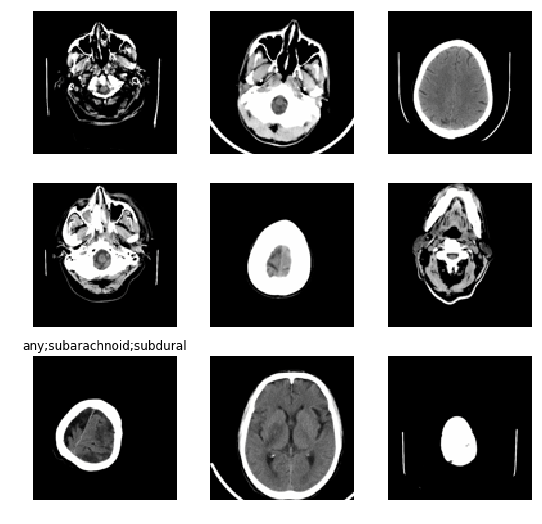

In [18]:
dbch.show_batch(max_n=9)

In [19]:
model = create_cnn_model(resnet18, 6, -2)

I define how I want to split the model for applying differential learing rates

In [20]:
model_segments = model[0][:6], model[0][6:], model[1]

In [21]:
def trainable_params_mod(model): return L(trainable_params(segment) for segment in model_segments)

In [22]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)

In [23]:
learn = Learner(
    dbch,
    model,
    loss_func=BCEWithLogitsLossFlat(),
    metrics=[accuracy_multi],
    opt_func=opt_func,
    splitter=trainable_params_mod
)

In [24]:
learn.freeze_to(-1)

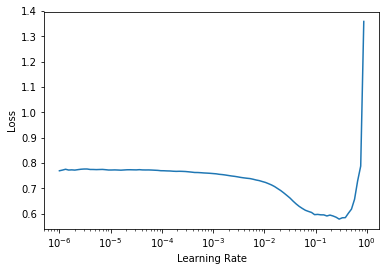

In [25]:
learn.lr_find(start_lr=1e-6, end_lr=1)

In [26]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.140526,0.110674,0.959328,04:04


In [27]:
learn.save('phase-1')

In [28]:
learn.load('phase-1');

In [29]:
learn.freeze_to(-2)

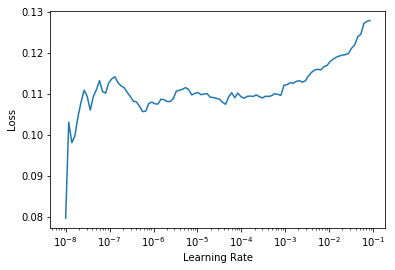

In [30]:
learn.lr_find(start_lr=1e-8, end_lr=1e-1)

In [31]:
learn.fit_one_cycle(1, [1e-5, 1e-4, 1e-3])

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.108200,0.104384,0.961552,04:29


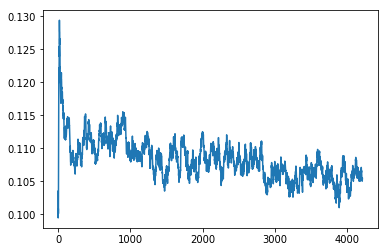

In [32]:
learn.recorder.plot_loss()

In [33]:
learn.save('phase-2')

In [34]:
learn.load('phase-2');

In [35]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(1, np.array([1e-5, 1e-4, 1e-3]))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.102819,0.100459,0.962915,05:15


In [37]:
learn.save('phase-3')

In [38]:
learn.load('phase-3')

In [39]:
learn.metrics = [PrecisionMulti(), RecallMulti()]

In [40]:
learn.validate()

[0.10045857727527618, 0.789031014543543, 0.48418313584654094]

One on hand, it is amazing that the switching of the databunches is possible. This is what flexibility and modularity looks like :) On the other hand, this is a hack.

This is only necessary right now because either this functionality in fastai v2 has not been added yet or I do not know how to go about this in a more proper way. I am sure the need for doing this will go away soon!

In [41]:
learn.dbunch = dbch_test

In [42]:
preds, targs = learn.get_preds()

/home/radek/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [43]:
preds = torch.sigmoid(preds)

In [44]:
ids = []
labels = []

for path, pred in zip(test_paths, preds):
    for i, label in enumerate(h_types):
        ids.append(f"{path.name.split('.')[0]}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [45]:
sub_name = 'resnet-18_starter_pack_fastai_v2'
pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'data/submissions/{sub_name}.csv.zip', compression='zip', index=False)

In [46]:
!kaggle competitions submit -c rsna-intracranial-hemorrhage-detection -f data/submissions/{sub_name}.csv.zip -m {sub_name}

100%|███████████████████████████████████████| 4.25M/4.25M [00:05<00:00, 797kB/s]
Successfully submitted to RSNA Intracranial Hemorrhage Detection